# NSE Table for Massive Stars

This notebook uses pynucastro to generate an NSE table for use with the Castro ``massive_star`` problem.
Previously we were using a table from the [Ma et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...771...58M/abstract)
paper which used 125 nuclei binned down into the 19 nuclei used in ``aprox19``.

This table will work similarly, with the main differences:

* We are using 84 nuclei presently.  This is because (1) we don't have all the weak
  rates for the 125 nuclei used originally and (2) some ofthe nuclei in the original
  set don't have valid spins.
  
* We go only down to $Y_e = 0.43$ instead of $Y_e = 0.4$ in the original table.
  This is because of the different set of nuclei -- it is harder to achieve such
  a low $Y_e$ with our set of nuclei.

* We are using a lower temperature bound of $T = 3\times 10^9~\mathrm{K}$ instead of $10^9~\mathrm{K}$
  in the original table.  This is mainly because we don't trust NSE below this temperature.

In [1]:
import pynucastro as pyna
from pynucastro import Nucleus

## Start get getting the nuclei we care about

In [2]:
nuc_list = [Nucleus("n"), Nucleus("p"), Nucleus("d"),
            Nucleus("he3"), Nucleus("he4"), Nucleus("c12"), Nucleus("o16"),
            Nucleus("ne20"), Nucleus("ne21"), Nucleus("ne22"), Nucleus("n13"), Nucleus("n14"), Nucleus("f18"),
            Nucleus("na23"), Nucleus("mg24"), Nucleus("si28"),
            Nucleus("s32"), Nucleus("ar36"), Nucleus("ca40"),
            Nucleus("al27"), Nucleus("p31"), Nucleus("cl35"), Nucleus("k39")]

We need to be careful with which nuclei we add, since some do not have spins

In [3]:
#nuc_list += pyna.get_nuclei_in_range(20, 20, 45, 48)
nuc_list += pyna.get_nuclei_in_range(21, 21, 43, 46)
nuc_list += pyna.get_nuclei_in_range(22, 22, 44, 49)
nuc_list += pyna.get_nuclei_in_range(23, 23, 47, 54)
nuc_list += pyna.get_nuclei_in_range(24, 24, 48, 56)
nuc_list += pyna.get_nuclei_in_range(25, 25, 51, 58)
nuc_list += pyna.get_nuclei_in_range(26, 26, 52, 60)
nuc_list += pyna.get_nuclei_in_range(27, 27, 54, 61) # 64
nuc_list += pyna.get_nuclei_in_range(28, 28, 56, 62) # 65
nuc_list.append(Nucleus("cu59"))
nuc_list.append(Nucleus("zn60"))

In [4]:
len(nuc_list)

84

## Create our network

Find all the rates that connect these nuclei in both the ReacLib library and the tabulated rates pynucastro knows about

In [5]:
tl = pyna.TabularLibrary()
rl = pyna.ReacLibLibrary()
tlib = tl.linking_nuclei(nuc_list)
rlib = rl.linking_nuclei(nuc_list)

In [7]:
rc = pyna.RateCollection(libraries=[rlib, tlib])

In [8]:
len(rc.get_rates())

755

Find any duplicates between ReacLib and the Langanke rates

In [9]:
dupes = rc.find_duplicate_links()

In [10]:
for d in dupes:
    for rate in d:
        print(f"{rate.fname:22} {type(rate)}")
    print()

sc46__ti46__weak__wc12 <class 'pynucastro.rates.rate.ReacLibRate'>
sc46__ti46             <class 'pynucastro.rates.rate.TabularRate'>

ti45__sc45__weak__wc12 <class 'pynucastro.rates.rate.ReacLibRate'>
ti45__sc45             <class 'pynucastro.rates.rate.TabularRate'>

v47__ti47__weak__wc12  <class 'pynucastro.rates.rate.ReacLibRate'>
v47__ti47              <class 'pynucastro.rates.rate.TabularRate'>

v48__ti48__weak__wc12  <class 'pynucastro.rates.rate.ReacLibRate'>
v48__ti48              <class 'pynucastro.rates.rate.TabularRate'>

v49__ti49__weak__wc12  <class 'pynucastro.rates.rate.ReacLibRate'>
v49__ti49              <class 'pynucastro.rates.rate.TabularRate'>

v52__cr52__weak__wc12  <class 'pynucastro.rates.rate.ReacLibRate'>
v52__cr52              <class 'pynucastro.rates.rate.TabularRate'>

v53__cr53__weak__wc12  <class 'pynucastro.rates.rate.ReacLibRate'>
v53__cr53              <class 'pynucastro.rates.rate.TabularRate'>

v54__cr54__weak__wc12  <class 'pynucastro.rates.rate.Re

The last one is special -- I think that ReacLib suggests you include both (although, it hardly matters for us here)

In [11]:
pp = dupes.pop()
print(pp)

[p + p ⟶ H2 + e⁺ + 𝜈, p + p + e⁻ ⟶ H2 + 𝜈]


Now remove the ReacLib rates in favor of tabular

In [12]:
from pynucastro.rates import ReacLibRate
rates_to_remove = []
for d in dupes:
    rates_to_remove += [r for r in d if isinstance(r, ReacLibRate)]
    
rc.remove_rates(rates_to_remove)

In [13]:
len(rc.get_rates())

719

Finally let's plot the network

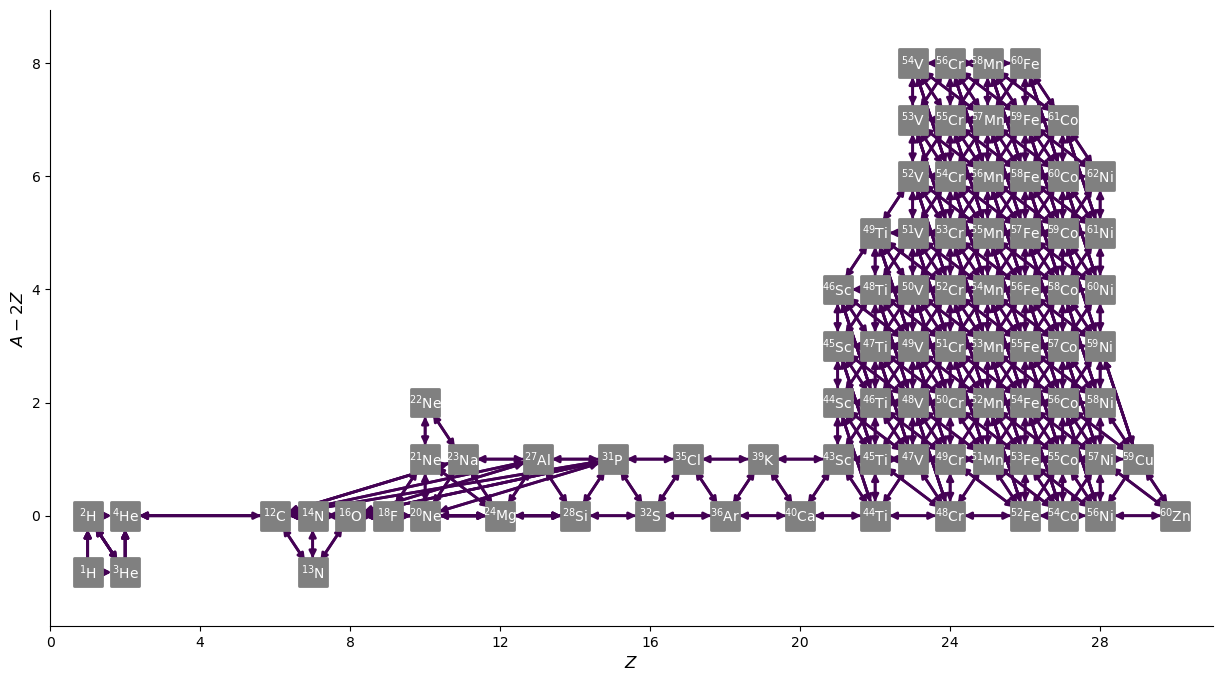

In [14]:
fig = rc.plot(hide_xalpha=True, hide_xp=True, rotated=True,
              size=(1500, 800), node_shape="s", node_size=400, node_font_size=10, node_color="0.5")

In [15]:
fig.savefig("nse_test.png")

## Test NSE solve

In [15]:
comp, sol = rc.get_comp_nse(1.e8, 6.e9, 0.48, use_coulomb_corr=True, return_sol=True)

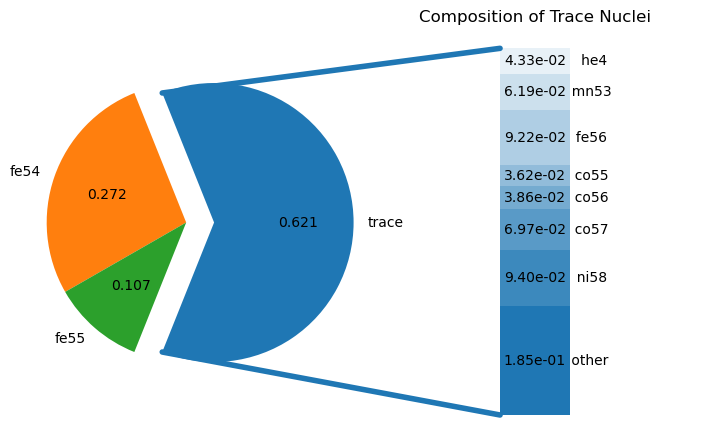

In [16]:
fig = comp.plot()

## Create the table

In [17]:
import numpy as np

$Y_e \sim 0.43$ is basically how low `aprox21` goes

In [18]:
#Ts = np.logspace(9, 10.4, 71)
#Ts = np.logspace(np.log10(3.e9), np.log10(2.5e10), 21)
Ts = np.logspace(np.log10(3.e9), np.log10(2.e10), 51)
rhos = np.logspace(7, 10, 31)
yes = np.linspace(0.43, 0.5, 15)

In [19]:
yes

array([0.43 , 0.435, 0.44 , 0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 ,
       0.475, 0.48 , 0.485, 0.49 , 0.495, 0.5  ])

In [20]:
for T in reversed(Ts):
    initial_guess = (-3.5, -15)
    print(f"working on {T=}")
    for rho in reversed(rhos):
        for n, ye in enumerate(reversed(yes)):
            try:
                comp, sol = rc.get_comp_nse(rho, T, ye, use_coulomb_corr=True,
                                            init_guess=initial_guess, return_sol=True)
            except ValueError:
                initial_guess = (-3.5, -15)
                comp, sol = rc.get_comp_nse(rho, T, ye, use_coulomb_corr=True,
                                            init_guess=initial_guess, return_sol=True)
                
            initial_guess = sol

working on T=20000000000.000004
working on T=19255367900.8936
working on T=18538459649.938107
working on T=17848243043.77147
working on T=17183724309.61923
working on T=16543946674.46229
working on T=15927988987.47683
working on T=15334964393.762403
working on T=14764019057.449883
working on T=14214330932.350092
working on T=13685108578.372646
working on T=13175590022.011961
working on T=12685041659.259155
working on T=12212757199.35984
working on T=11758056647.898033
working on T=11320285327.741173
working on T=10898812936.437208
working on T=10493032638.705847
working on T=10102360192.71823
working on T=9726233108.906593
working on T=9364109840.092428
working on T=9015469001.767845
working on T=8679808621.407091
working on T=8356645415.727081
working on T=8045514094.857012
working on T=7745966692.414836
working on T=7457571920.52578
working on T=7179914548.854847
working on T=6912594806.758928
working on T=6655227807.697483
working on T=6407442995.073604
working on T=6168883608.70729

In [21]:
print(T, rho, ye)

3000000000.000001 10000000.0 0.43


In [40]:
print(sol)

[-13.6958364   -5.22976651]


In [41]:
initial_guess

array([-13.6958364 ,  -5.22976651])